<h3> Create and Save a Barscan Calibration from a Sequence of Files</h3>

Most relevant function here is [calculate_barscan_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.calculate_barscan_calibration).

The output of <code>calculate_barscan_calibration</code> outputs an object containing two parts: a <b>metadata</b> (instrument name, day stamp, name of the double-detector-array), and the proper calibration data, contained in a Mantid <b>table</b> object.

In [1]:
#
# "plot_workspace" is a utility function, which we will use a couple of times
#
%matplotlib inline
from drtsans.mono.gpsans import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

/SNS/software/miniconda2/envs/sans-dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<h4>Saving memory by transforming the events files into histograms</h4>

Although not necessary in the analysis machines, we're going to transform these events files to histogram files, thus reducing their size to about 20% the original size. We'll use these histogram files for the calibration.

This takes up quite a bit of time, so **it should be done only once**.

In [3]:
first_run, last_run = 9905, 10016
data_files = '/HFIR/CG2/IPTS-23801/nexus/CG2_{0}.nxs.h5'
save_dir = '/tmp/pixel_calibration'

import os
from mantid.simpleapi import LoadEventNexus, HFIRSANS2Wavelength, SaveNexus, DeleteWorkspaces

os.makedirs(save_dir, exist_ok=True)

print('Processing runs:')
for run in range(first_run, 1 + last_run):
    print(run, ', ', end='')

    workspace_events = 'events_{0}'.format(run)
    LoadEventNexus(Filename=data_files.format(run), LoadMonitors=False, OutputWorkspace=workspace_events)

    workspace_counts = 'counts_{0}'.format(run)
    HFIRSANS2Wavelength(InputWorkspace=workspace_events, OutputWorkspace=workspace_counts)

    file_histogram = save_dir + workspace_counts + '.nxs'
    SaveNexus(InputWorkspace='counts_{0}'.format(run), Filename=file_histogram)
    DeleteWorkspaces([workspace_events, workspace_counts])

Processing runs:
9905 , 9906 , 9907 , 9908 , 9909 , 9910 , 9911 , 9912 , 9913 , 9914 , 9915 , 9916 , 9917 , 9918 , 9919 , 9920 , 9921 , 9922 , 9923 , 9924 , 9925 , 9926 , 9927 , 9928 , 9929 , 9930 , 9931 , 9932 , 9933 , 9934 , 9935 , 9936 , 9937 , 9938 , 9939 , 9940 , 9941 , 9942 , 9943 , 9944 , 9945 , 9946 , 9947 , 9948 , 9949 , 9950 , 9951 , 9952 , 9953 , 9954 , 9955 , 9956 , 9957 , 9958 , 9959 , 9960 , 9961 , 9962 , 9963 , 9964 , 9965 , 9966 , 9967 , 9968 , 9969 , 9970 , 9971 , 9972 , 9973 , 9974 , 9975 , 9976 , 9977 , 9978 , 9979 , 9980 , 9981 , 9982 , 9983 , 9984 , 9985 , 9986 , 9987 , 9988 , 9989 , 9990 , 9991 , 9992 , 9993 , 9994 , 9995 , 9996 , 9997 , 9998 , 9999 , 10000 , 10001 , 10002 , 10003 , 10004 , 10005 , 10006 , 10007 , 10008 , 10009 , 10010 , 10011 , 10012 , 10013 , 10014 , 10015 , 10016 , 

In [4]:
first_run, last_run = 9905, 10016
save_dir = '/tmp/pixel_calibration'
barscan_dataset = list()  # list of histogram files
for run in range(first_run, 1 + last_run):
    file_histogram = save_dir + 'counts_{0}.nxs'.format(run)
    barscan_dataset.append(file_histogram)

We can inspect a few of the bar scans by looking at the intensity pattern on a detector with default (uncalibrated) detector heights and positions

inspection_9905
inspection_9932
inspection_9959
inspection_9986
inspection_10013


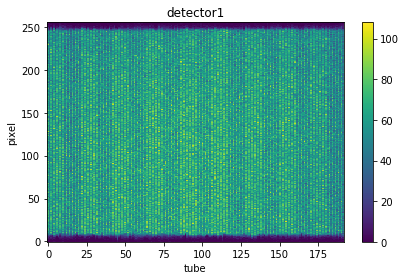

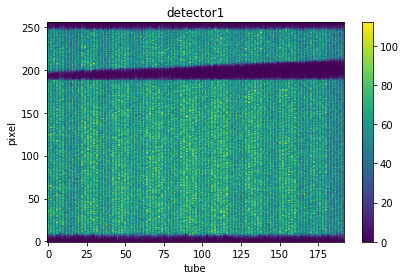

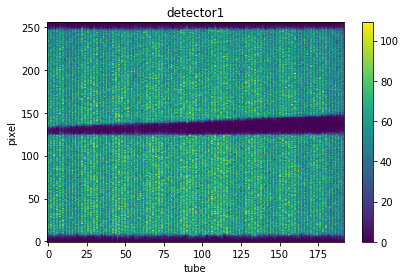

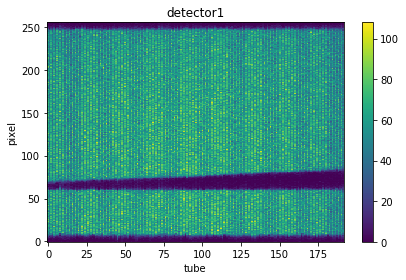

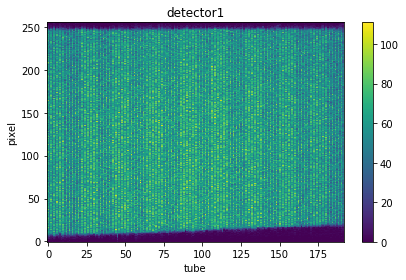

In [5]:
from mantid.simpleapi import LoadNexus

delta = int((last_run - first_run ) / 4)
for index, run in enumerate(range(first_run, last_run, delta)):
    output_workspace = 'inspection_{0}'.format(run)
    print(output_workspace)
    LoadNexus(Filename=barscan_dataset[index * delta], OutputWorkspace=output_workspace)
    plot_workspace(output_workspace)

<h4>Calculate the barscan</h4>

We are using the **default formula** for the position of the bar:  
<code>565 - {y} - 0.0914267 * (191 - {tube})</code>  

- <code>{y}</code> is the bar position reported in the log.
- <code>{tube}</code> is the index of each tube, with index zero being the leftmost tube when viewed from the sample's position. Required if **the bar is not completely horizontal**, but it's inclined.

In [6]:
import time
from drtsans.mono.gpsans import calculate_barscan_calibration

start_time = time.time()
formula = '565 - {y} - 0.0914267 * (191 - {tube})'
calibration = calculate_barscan_calibration(barscan_dataset, formula=formula)
print('Calibration took ', int((time.time() - start_time) / 60), 'minutes')

Calibration took  6 minutes


We can visualize the calibration by coloring each pixel according to its height, or according to its position. Then we show a 2D plot of the pixel colors. For this purpose we create "views" with the `as_intensities()` method of the calibration object.

We must pass a reference workspace to method `as_intensities()`, which could be one of our inspection runs

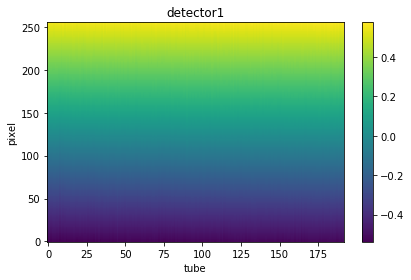

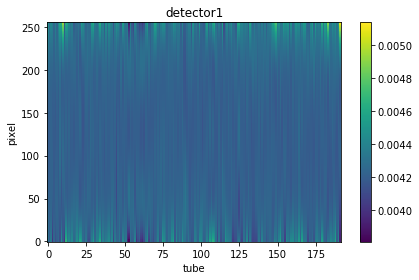

In [7]:
views = calibration.as_intensities('inspection_{0}'.format(first_run))
plot_workspace(views.positions)  # views.positions is a workspace containing pixel positions as pixel counts
plot_workspace(views.heights)  # views.heights is a workspace containing pixel positions as pixel counts

We can also inspect the result of applying the calibration to one of the barscan files, before saving the calibratoin to the database

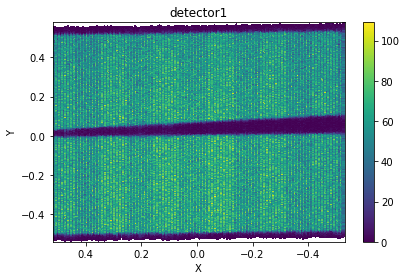

In [8]:
calibration.apply('inspection_9959', output_workspace='inspection_9959_calibrated')
plot_workspace('inspection_9959_calibrated', axes_mode='xy')

The previous plot shows a tilted bar, indicating that the slope in the formula of the bar position is **not required**

In [9]:
formula = '565 - {y}'  # no tilted bar
calibration = calculate_barscan_calibration(barscan_dataset, formula=formula)

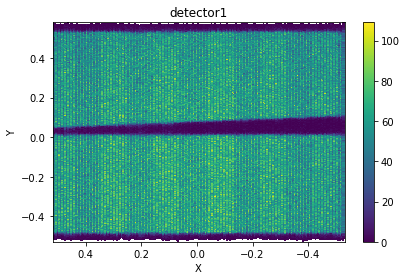

In [10]:
calibration.apply('inspection_9959', output_workspace='inspection_9959_calibrated')
plot_workspace('inspection_9959_calibrated', axes_mode='xy')

This time the calibration looks better, it's ready to be saved

<h5>Calibration objects are saved to a database as two separate pieces:</h5>

- metadata (instrument name, day stamp, name of the double-detector-array) is save to a JSON file.  
- data (a table workspace) is saved to a Nexus file with SaveNexus.  

There's a default database for every instrument. The GPSANS location for the metadata JSON file:

- GPSANS: <b>/HFIR/CG2/shared/calibration/pixel_calibration.json</b>

Data tables are saved under `tables/` subdirectory:

- GPSANS: <b>/HFIR/CG2/shared/calibration/tables</b>

<h5>Calibration objects have method "<b>save</b>" to save itself to the the database. The full signature of this method:</h5>

    def save(self, database=None, tablefile=None, overwrite=False):
        r"""
        Save the calibration metadata in a JSON file, and the calibration table workspace in a Nexus file.

        Parameters
        ----------
        database: str
            Path to the JSON file where the ```metadata``` dictionary will be appended. If :py:obj:`None`,
            then the appropriate default file from ~drtsans.pixel_calibration.database_file is used.
            Currently, these are the default files:
            - BIOSANS, '/HFIR/CG3/shared/calibration/pixel_calibration.json',
            - EQSANS, '/SNS/EQSANS/shared/calibration/pixel_calibration.json',
            - GPSANS, '/HFIR/CG2/shared/calibration/pixel_calibration.json'
        tablefile: str
            Path to the Nexus file storing the pixel calibration data. If :py:obj:`None`, then
            a composite name is created using the calibration type, instrument, component,
            and daystamp. (e.g. "barscan_gpsans_detector1_20200311"). The file is saved under
            subdirectory 'tables', located within the directory of the ```database``` file.
            For instance, '/HFIR/CG3/shared/calibration/tables/barscan_gpsans_detector1_20200311.nxs'
        overwrite: bool
            Substitute existing entry with same metadata

        Raises
        ------
        ValueError
            If we save a calibration already in the database with option ```overwrite=False```.
        """

In [11]:
# Notice we overwrite the already saved calibration, which will happen if we run this notebook more than once.
calibration.save(overwrite=True)

<h4>Load and Apply a Barscan Calibration</h4>

Most relevant function is [apply_calibrations](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.apply_calibrations)

We apply the barscan calibration to flood run 10502

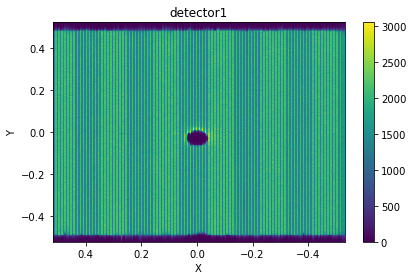

In [12]:
from mantid.simpleapi import LoadEventNexus, HFIRSANS2Wavelength
LoadEventNexus(Filename='/HFIR/CG2/IPTS-23801/nexus/CG2_10502.nxs.h5', OutputWorkspace='flood_run')
HFIRSANS2Wavelength(InputWorkspace='flood_run', OutputWorkspace='flood_run')
plot_workspace('flood_run', axes_mode='xy')

We apply the calibration in the database which we saved in the previous section.

<code>
def apply_calibrations(input_workspace, database=None, calibrations=[cal.name for cal in CalType],
                       output_workspace=None):

    Load and apply pixel calibrations to an input workspace.

    devs - Jose Borreguero <borreguerojm@ornl.gov>

    Parameters
    ----------
    input_workspace: str, ~mantid.api.MatrixWorkspace, ~mantid.api.IEventWorkspace
        Input workspace whose pixels are to be calibrated.
    database: str
        Path to JSON file containing metadata for different past calibrations. If :py:obj:`None`,
        the default database is used. Currently, these are the default files:
        - BIOSANS, '/HFIR/CG3/shared/calibration/pixel_calibration.json',
        - EQSANS, '/SNS/EQSANS/shared/calibration/pixel_calibration.json',
        - GPSANS, '/HFIR/CG2/shared/calibration/pixel_calibration.json'
    calibrations: str, list
        One or more of 'BARSCAN' and/or 'TUBEWIDTH'.
    output_workspace: str
         Name of the output workspace with calibrated pixels. If :py:obj:`None`, the pixels
        of the input workspace will be calibrated.
</code>

Again we plot the pixel intensities on the main detector and visually compare to the previous plot.

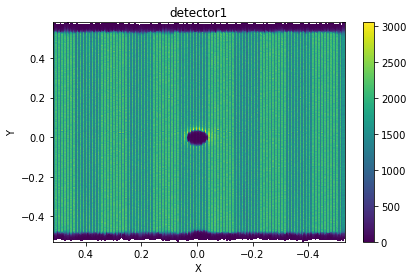

In [13]:
from drtsans.mono.gpsans import apply_calibrations
apply_calibrations('flood_run', calibrations='BARSCAN', output_workspace='flood_run_calibrated')
plot_workspace('flood_run_calibrated', axes_mode='xy')

<h3> Create and Save a Barscan Calibration from a Single File</h3>

Most relevant function here is [calculate_barscan_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.calculate_barscan_calibration).

The output of <code>calculate_barscan_calibration</code> outputs an object containing two parts: a <b>metadata</b> (instrument name, day stamp, name of the double-detector-array), and the proper calibration data, contained in a Mantid <b>table</b> object.

In [14]:
#
# "plot_workspace" is a utility function, which we will use a couple of times
#
%matplotlib inline
from drtsans.mono.gpsans import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

The barscan file we'll use (CG2_7465.nxs.h5) contains a full barscan with 110 different positions for the bar. We can either directly pass this file to function `calculate_barscan_calibration` or we can split the barscan run into individual files, each having the bar at a particular position. This allows us to take a look and see how the scan went down.

We split the barscan with function `split_barscan_run` and the script below. I have commented the script because I already splitted the file.

In [ ]:
"""
from drtsans.mono.gpsans import split_barscan_run
output_directory = '/HFIR/CG2/shared/sans-backend/data/new/ornl/sans/hfir/gpsans/pixel_calibration/runs_7465'
barscan_file = '/HFIR/CG2/shared/sans-backend/data/new/ornl/sans/hfir/gpsans/pixel_calibration/CG2_7465.nxs.h5'
split_barscan_run(barscan_file, output_directory)
"""

The barscan contained 110 different positions of the bar. Let's take a look to position 55

In [ ]:
from mantid.simpleapi import LoadNexus
LoadNexus('/HFIR/CG2/shared/sans-backend/data/new/ornl/sans/hfir/gpsans/pixel_calibration/runs_7465/CG2_7465_55.nxs',
          OutputWorkspace='scan_55')

In [ ]:
plot_workspace('scan_55')

Some of the tubes behave quite badly.

Below we gather the names of all files in a list

In [ ]:
import os
data_dir = '/HFIR/CG2/shared/sans-backend/data/new/ornl/sans/hfir/gpsans/pixel_calibration/runs_7465'
barscan_dataset = [os.path.join(data_dir, f'CG2_7465_{i}.nxs') for i in range(111)]  # ranges from 0 to 110

In [ ]:
import time
from drtsans.mono.gpsans import calculate_barscan_calibration

start_time = time.time()
calibration = calculate_barscan_calibration(barscan_dataset)  # calibration for array 'detector1'
print('Calibration took ', int((time.time() - start_time) / 60), 'minutes')

We can visualize the calibration by coloring each pixel according to its height, or according to its position. Then we show a 2D plot of the pixel colors. For this purpose we create "views" with the `as_intensities()` method of the calibration object.

We must pass a reference workspace to `as_intensities()`, which could be our barscan run or one of the individual scans.

In [ ]:
views = calibration.as_intensities('scan_55')

In [ ]:
plot_workspace(views.positions)  # views.positions is a workspace containing pixel positions as pixel counts
plot_workspace(views.heights)  # views.heights is a workspace containing pixel positions as pixel counts

<h5>Calibration objects are saved to a database as two separate pieces:</h5>

- metadata (instrument name, day stamp, name of the double-detector-array) is save to a JSON file.  
- data (a table workspace) is saved to a Nexus file with SaveNexus.  

There's a default database for every instrument. The GPSANS location for the metadata JSON file:

- GPSANS: <b>/HFIR/CG2/shared/calibration/pixel_calibration.json</b>

Data tables are saved under `tables/` subdirectory:

- GPSANS: <b>/HFIR/CG2/shared/calibration/tables</b>

<h5>Calibration objects have method "<b>save</b>" to save itself to the the database. The full signature of this method:</h5>

    def save(self, database=None, tablefile=None, overwrite=False):
        r"""
        Save the calibration metadata in a JSON file, and the calibration table workspace in a Nexus file.

        Parameters
        ----------
        database: str
            Path to the JSON file where the ```metadata``` dictionary will be appended. If :py:obj:`None`,
            then the appropriate default file from ~drtsans.pixel_calibration.database_file is used.
            Currently, these are the default files:
            - BIOSANS, '/HFIR/CG3/shared/calibration/pixel_calibration.json',
            - EQSANS, '/SNS/EQSANS/shared/calibration/pixel_calibration.json',
            - GPSANS, '/HFIR/CG2/shared/calibration/pixel_calibration.json'
        tablefile: str
            Path to the Nexus file storing the pixel calibration data. If :py:obj:`None`, then
            a composite name is created using the calibration type, instrument, component,
            and daystamp. (e.g. "barscan_gpsans_detector1_20200311"). The file is saved under
            subdirectory 'tables', located within the directory of the ```database``` file.
            For instance, '/HFIR/CG3/shared/calibration/tables/barscan_gpsans_detector1_20200311.nxs'
        overwrite: bool
            Substitute existing entry with same metadata

        Raises
        ------
        ValueError
            If we save a calibration already in the database with option ```overwrite=False```.
        """

In [ ]:
# Notice we overwrite the already saved calibration, which will happen if we run this notebook more than once.
calibration.save(overwrite=True)

<h4>Load and Apply a Barscan Calibration</h4>

Most relevant function is [load_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.load_calibration)

In [ ]:
import os
from mantid.simpleapi import LoadNexus
from drtsans.mono.gpsans import load_calibration

# "plot_workspace" is a utility function, which we will use a couple of times
%matplotlib inline
from drtsans.mono.gpsans import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

Below we load the run to which we will apply the calibration. It is one of the scans, with the bar positioned past the middle of the detector.  
We take a look by plotting the pixel intensities on the main detector.

In [ ]:
# Load the run to which we will apply the calibration
data_dir = '/HFIR/CG2/shared/sans-backend/data/new/ornl/sans/hfir/gpsans/pixel_calibration'
LoadNexus(os.path.join(data_dir, 'scan_88.nxs'), OutputWorkspace='scan_88')

plot_workspace('scan_88', axes_mode='xy')

Notice in the previous plot some spikes in the shadow cast by the bar. The spikes indicate tubes that need badly to be calibrated.

Loading a calibration with [load_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.load_calibration) requires at least a target workspace and the type of calibration to be loaded. This functions return a calibration object.

The calibration object has method <b>apply</b> to apply itself into a target workspace. Here's the full documentation for this method:

    def apply(self, input_workspace, output_workspace=None):
        r"""
        Apply a calibration to an input workspace, and return the calibrated workspace.

        Parameters
        ----------
        input_workspace: str, ~mantid.api.MatrixWorkspace, ~mantid.api.IEventsWorkspace
            Workspace to which calibration needs to be applied.
        output_workspace: str
            Name of the output workspace with calibrated pixels. If :py:obj:`None`, the pixels
            of the input workspace will be calibrated and no new workspace is generated.

        Returns
        -------
        ~mantid.api.MatrixWorkspace, ~mantid.api.IEventsWorkspace
        """

In [ ]:
calibration = load_calibration('scan_88', 'BARSCAN')
# Apply the calibration.
start_time = time.time()
calibration.apply('scan_88')
print(f'Applying the calibration took {time.time() - start_time:.1} seconds')

Again we plot the pixel intensities on the main detector and visually compare to the previous plot.

In [ ]:
plot_workspace('scan_88', axes_mode='xy')

In the calibrated workpace, the shadow spikes tend to be supressed.

<h3>Calculate Tube Width Calibration</h3>

Relevant function is [calculate_apparent_tube_width](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.calculate_apparent_tube_width)

In [15]:
import time
from mantid.simpleapi import LoadEventNexus, HFIRSANS2Wavelength
from drtsans.mono.gpsans import calculate_apparent_tube_width

#
# "plot_workspace" is a utility function, which we will use a couple of times
#
from drtsans.mono.gpsans import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

In [16]:
LoadEventNexus(Filename='/HFIR/CG2/IPTS-23801/nexus/CG2_10502.nxs.h5', OutputWorkspace='flood_run')
HFIRSANS2Wavelength(InputWorkspace='flood_run', OutputWorkspace='flood_workspace')

Workspace2D
Title: Flood_center
Histograms: 49152
Bins: 1
Histogram
X axis: Wavelength / Angstrom
Y axis: Counts
Distribution: False
Instrument: CG2 (2019-Oct-01 to 2100-Dec-31)Instrument from: /HFIR/CG2/IPTS-23801/nexus/CG2_9905.nxs.h5

Parameters from: /SNS/users/jbq/.mantid/instrument/CG2_Parameters.xml
Run start: 2020-May-01 18:20:04
Run end:  2020-May-01 20:20:04

We have masked the beam center and saved the mask in a file. Here we apply the mask to the workspace using `apply_mask`

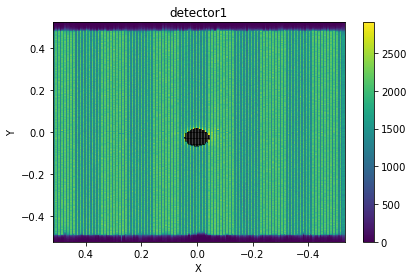

In [17]:
from drtsans.mono.gpsans import apply_mask
mask_file = '/HFIR/CG2/shared/sans-backend/data/new/ornl/sans/hfir/gpsans/pixel_calibration/flood_files/mask_CG2_8143.xml'
apply_mask('flood_workspace', mask=mask_file)

plot_workspace('flood_workspace', axes_mode='xy')

Calculation of the apparent tube width requires that the pixel positions and heights have been calibrated with a barscan. If no good barscan is present in the database, we can use the default pixel positions and heights defined in the instrument defintion file by setting <code>load_barscan_calibration=False</code>


In [18]:
start_time = time.time()
calibration = calculate_apparent_tube_width('flood_workspace', load_barscan_calibration=True)
print('Calibration took ', int(time.time() - start_time), 'seconds')

Calibration took  2 seconds


<h5>Calibration objects are saved to a database as two separate pieces:</h5>

- metadata (instrument name, day stamp, name of the double-detector-array) is save to a JSON file.  
- data (a table workspace) is saved to a Nexus file with SaveNexus.  

There's a default database for every instrument. The GPSANS location for the metadata JSON file:

- GPSANS: <b>/HFIR/CG2/shared/calibration/pixel_calibration.json</b>

Data tables are saved under `tables/` subdirectory:

- GPSANS: <b>/HFIR/CG2/shared/calibration/tables</b>

<h5>Calibration objects have method "<b>save</b>" to save itself to the the database. The full signature of this method:</h5>

    def save(self, database=None, tablefile=None, overwrite=False):
        r"""
        Save the calibration metadata in a JSON file, and the calibration table workspace in a Nexus file.

        Parameters
        ----------
        database: str
            Path to the JSON file where the ```metadata``` dictionary will be appended. If :py:obj:`None`,
            then the appropriate default file from ~drtsans.pixel_calibration.database_file is used.
            Currently, these are the default files:
            - BIOSANS, '/HFIR/CG3/shared/calibration/pixel_calibration.json',
            - EQSANS, '/SNS/EQSANS/shared/calibration/pixel_calibration.json',
            - GPSANS, '/HFIR/CG2/shared/calibration/pixel_calibration.json'
        tablefile: str
            Path to the Nexus file storing the pixel calibration data. If :py:obj:`None`, then
            a composite name is created using the calibration type, instrument, component,
            and daystamp. (e.g. "barscan_gpsans_detector1_20200311"). The file is saved under
            subdirectory 'tables', located within the directory of the ```database``` file.
            For instance, '/HFIR/CG3/shared/calibration/tables/barscan_gpsans_detector1_20200311.nxs'
        overwrite: bool
            Substitute existing entry with same metadata

        Raises
        ------
        ValueError
            If we save a calibration already in the database with option ```overwrite=False```.
        """

In [19]:
# Notice we overwrite the already saved calibration, which will happen if we run this notebook more than once.
calibration.save(overwrite=True)

<h4>Load and Apply a Tube Width Calibration</h4>

In function <code>linear_density</code> below, we integrate the total intensity per tube and divide by the number of non-masked pixels in the tube, and by the tube width. Front end tubes collect more intentity than the back tubes. Similarly, front end tubes have a larger apparent tube width than back tubes. The ratio of total intensity to width should be similar for front and end tubes after the calibration.First some general imports and a couple of custom plotting functions

In [25]:
import numpy as np
from drtsans.tubecollection import TubeCollection
from matplotlib import pyplot as plt

#
# "plot_histograms" to create fancy plots of the spectram stored in an input workspace
#
def plot_histograms(input_workspace, legend=[], xlabel='X-axis', ylabel='Y-axis', title='', linewidths=[]):
    r"""Line plot for the histograms of a workspace"""
    workspace = mtd[str(input_workspace)]
    number_histograms = workspace.getNumberHistograms()
    if len(legend) != number_histograms:
        legend = [str(i) for i in range(number_histograms)]
    if len(linewidths) != number_histograms:
        linewidths = [1] * number_histograms
    fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
    for workspace_index in range(number_histograms):
        ax.plot(workspace, wkspIndex=workspace_index, label=legend[workspace_index],
                linewidth=linewidths[workspace_index])
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.tick_params(axis='x', direction='in')
    ax.tick_params(axis='y', direction='out')
    ax.grid(True)
    fig.show()

def linear_density(workspace):
    r"""Tube total intensity per non-masked pixel and per unit length of tube width"""
    collection = TubeCollection(workspace, 'detector1').sorted(view='fbfb')
    intensities = np.array([np.sum(tube.readY) for tube in collection])
    widths = np.array([tube.width for tube in collection])
    number_pixels_not_masked = np.array([np.sum(~tube.isMasked) for tube in collection])
    return list(intensities / (number_pixels_not_masked * widths))

    We apply the barscan calibration, and the tube width calibration that we just saved

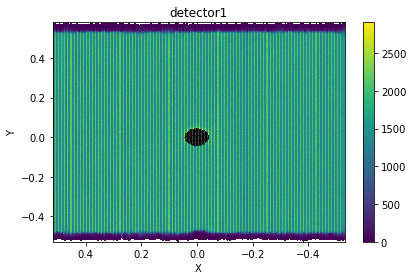

In [21]:
from drtsans.mono.gpsans import apply_calibrations
# apply bar scan and tube width calibrations
apply_calibrations('flood_workspace', output_workspace='flood_workspace_calibrated')
plot_workspace('flood_workspace_calibrated', axes_mode='xy')

We store both linear densities in a workspace, and then we'll use matplotlib to plot both densities

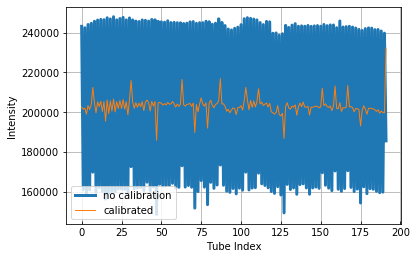

In [26]:
from mantid.simpleapi import CreateWorkspace
from mantid.api import mtd

uncalibrated_densities = linear_density('flood_workspace')
calibrated_densities = linear_density('flood_workspace_calibrated')

number_tubes = len(uncalibrated_densities)
CreateWorkspace(DataX=range(number_tubes),
                DataY=np.array([uncalibrated_densities, calibrated_densities]),
                NSpec=2,   # two histograms
                Outputworkspace='linear_densities')
plot_histograms('linear_densities',
                legend=['no calibration', 'calibrated'],
                xlabel='Tube Index', ylabel='Intensity', linewidths=[3, 1])

The oslillating intensities in the linear densities have been suppresed for most tubes, indicating the calibration is working.

<h3>Loading and Applying a Pixel Calibration (Barscan plus Tube-Width)</h3>

Relevant function is [apply_calibrations](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.apply_calibrations), which will search for <code>BARSCAN</code> and <code>TUBEWIDTH</code> calibrations appropriate to the target run

In [27]:
import time
from mantid.simpleapi import LoadEventNexus
from drtsans.mono.gpsans import apply_calibrations

#
# "plot_workspace" is a utility function, which we will use a couple of times
#
from drtsans.mono.gpsans import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

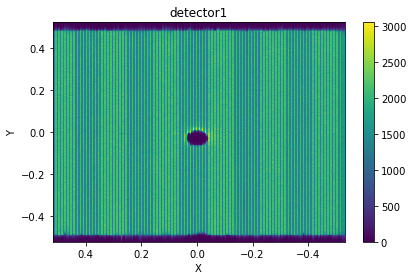

In [28]:
LoadEventNexus(Filename='/HFIR/CG2/IPTS-23801/nexus/CG2_10502.nxs.h5', OutputWorkspace='workspace')
HFIRSANS2Wavelength(InputWorkspace='flood_run', OutputWorkspace='workspace')
plot_workspace('workspace', axes_mode='xy')

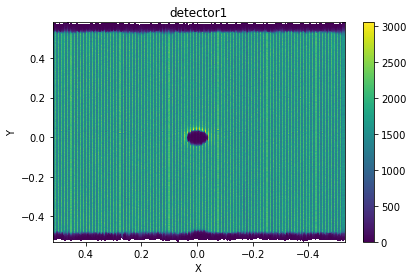

In [29]:
apply_calibrations('workspace')
plot_workspace('workspace', axes_mode='xy')

We can see when the BARSCAN calibration was taken, and the time when the input data was taken. For this we use function [load_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.load_calibration) and function <code>day_stamp</code>.

In [30]:
from drtsans.mono.gpsans import load_calibration, day_stamp
calibration = load_calibration('workspace', 'BARSCAN')
print('BARSCAN taken on', calibration.daystamp)
print('Input data taken on ', day_stamp('workspace'))

BARSCAN taken on 20200501
Input data taken on  20200501
